# User-Interface for Res-IRF
The Res-IRF model is a tool for simulating energy consumption for space heating in the French residential sector.

Its main characteristic is to integrate a detailed description of the energy performance of the dwelling stock with a rich description of household behaviour.

This notebook is an example of post-treatment.

Variable used by this notebook:
- cost intangible (to be done)
- cost construction
- cost envelope
- stock segmented
- stock construction segmented
- consumption

In [13]:
import pickle
import os
from ui_utils import *
from matplotlib import pyplot

User need to enter folder's name:

In [15]:
name_folder = '20210521_155245'

In [20]:
folder_output = os.path.join(os.getcwd(), 'output', name_folder)
print('Output will be taken from: {}'.format(folder_output))
folder_detailed = os.path.join(folder_output, 'detailed')
print('Output will be taken from: {}'.format(folder_detailed))

Output will be taken from: /Users/lucas/PycharmProjects/Res-IRF/project/output/20210521_155245
Output will be taken from: /Users/lucas/PycharmProjects/Res-IRF/project/output/20210521_155245/detailed


In [17]:
var_list = [
    'cost_intangible',
    'cost_construction',
    'cost_envelope',
    'demography',
    'stock_segmented',
    'stock_construction_segmented',
]
var_dict = {}
for key in var_list:
    name_file = os.path.join(folder_output, '{}.pkl'.format(key))
    with open(name_file, 'rb') as handle:
        var_dict[key] = pickle.load(handle)
        print('Reading: {}'.format(name_file))

Reading: /Users/lucas/PycharmProjects/Res-IRF/project/output/20210521_155245/cost_intangible.pkl
Reading: /Users/lucas/PycharmProjects/Res-IRF/project/output/20210521_155245/cost_construction.pkl
Reading: /Users/lucas/PycharmProjects/Res-IRF/project/output/20210521_155245/cost_envelope.pkl
Reading: /Users/lucas/PycharmProjects/Res-IRF/project/output/20210521_155245/demography.pkl
Reading: /Users/lucas/PycharmProjects/Res-IRF/project/output/20210521_155245/stock_segmented.pkl
Reading: /Users/lucas/PycharmProjects/Res-IRF/project/output/20210521_155245/stock_construction_segmented.pkl


In [27]:
var_detailed_list = [
    'consumption_info_dict',
    'capex_total_dict',
    'subsidies_total_dict',
    'subsidies_detailed_dict',
    'flow_renovation_label_energy_dict'
]
for key in var_detailed_list:
    name_file = os.path.join(folder_detailed, '{}.pkl'.format(key))
    with open(name_file, 'rb') as handle:
        var_dict[key] = pickle.load(handle)
        print('Reading: {}'.format(name_file))

Reading: /Users/lucas/PycharmProjects/Res-IRF/project/output/20210521_155245/detailed/consumption_info_dict.pkl
Reading: /Users/lucas/PycharmProjects/Res-IRF/project/output/20210521_155245/detailed/capex_total_dict.pkl
Reading: /Users/lucas/PycharmProjects/Res-IRF/project/output/20210521_155245/detailed/subsidies_total_dict.pkl
Reading: /Users/lucas/PycharmProjects/Res-IRF/project/output/20210521_155245/detailed/subsidies_detailed_dict.pkl
Reading: /Users/lucas/PycharmProjects/Res-IRF/project/output/20210521_155245/detailed/flow_renovation_label_energy_dict.pkl


## Energy consumption
Thanks to renovation, demolition and construction energy consumption tends to decrease over time in the reference case.
Energy consumption actual considers rebound effect.

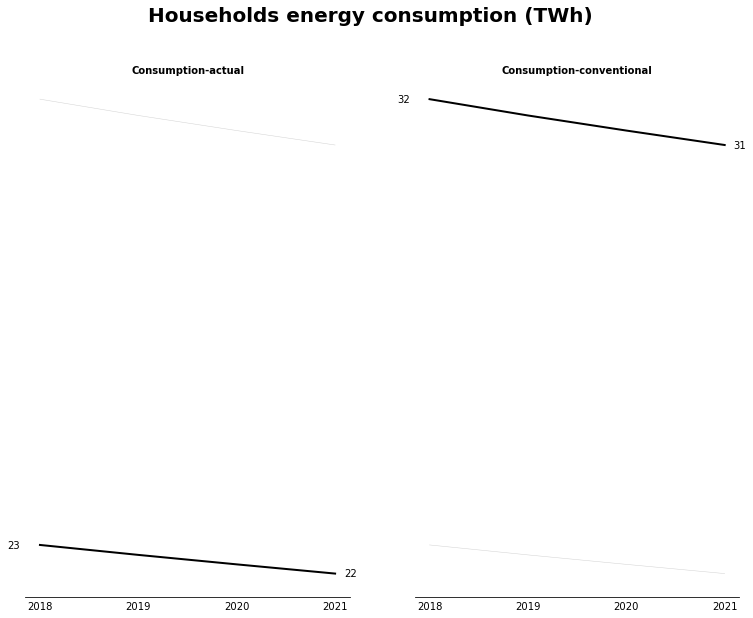

In [23]:
consumption = dict(reverse_nested_dict(var_dict['consumption_info_dict']))
consumption = concat_yearly_dict(consumption)
consumption_actual = consumption['Consumption-actual'] * var_dict['stock_segmented']
consumption_conventional = consumption['Consumption-conventional'] * var_dict['stock_segmented']
consumption = pd.concat((consumption_actual.sum(), consumption_conventional.sum()), axis=1).T
consumption.index = ['Consumption-actual', 'Consumption-conventional']

economic_subplots(consumption, 'Households energy consumption (TWh)', n_columns=2,
                  format_val=lambda x: '{:,.0f}'.format(x / 10000000000))

## Renovation cost

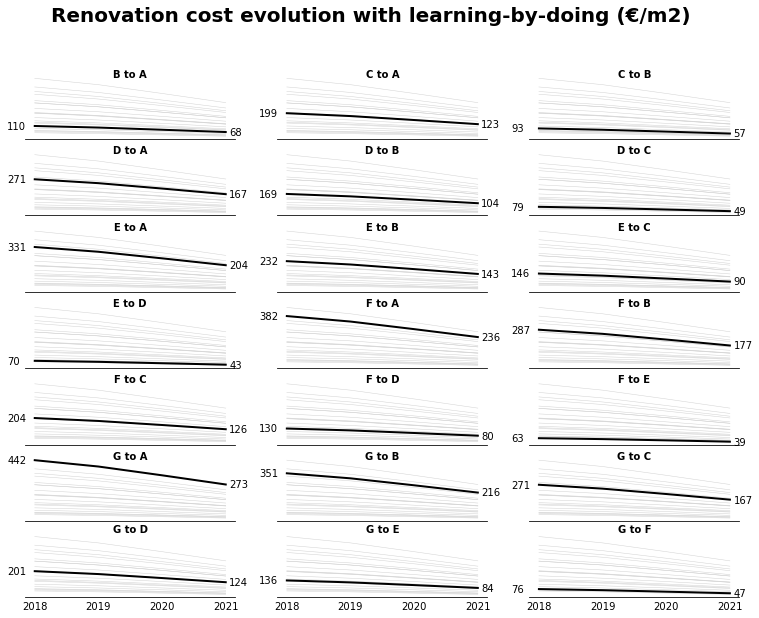

In [24]:
economic_subplots(var_dict['cost_envelope'], 'Renovation cost evolution with learning-by-doing (€/m2)',
                  format_axtitle=lambda x: '{} to {}'.format(x[0], x[1]), format_val=lambda x: '{:.0f}'.format(x))

## Evolution of dwelling stock

### Dwellings stocks by Energy performance

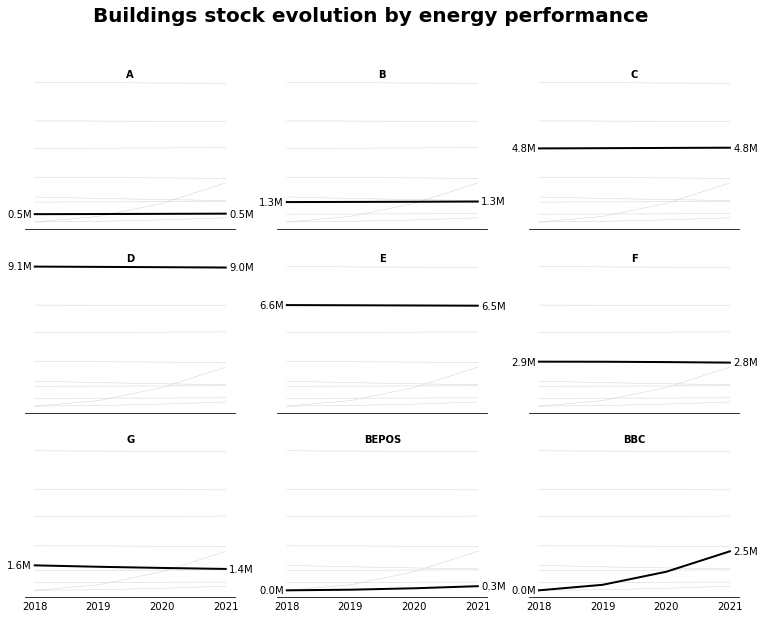

In [25]:
df = pd.concat((var_dict['stock_segmented'], var_dict['stock_construction_segmented']), axis=0)
df_ep = df.groupby(['Energy performance']).sum()
df_ep = df_ep.loc[['A', 'B', 'C', 'D', 'E', 'F', 'G', 'BEPOS', 'BBC']]
economic_subplots(df_ep, 'Buildings stock evolution by energy performance',
                  format_axtitle=lambda x: x, format_val=lambda x: '{:.1f}M'.format(x / 1000000))

### Dwellings stocks by Heating energy

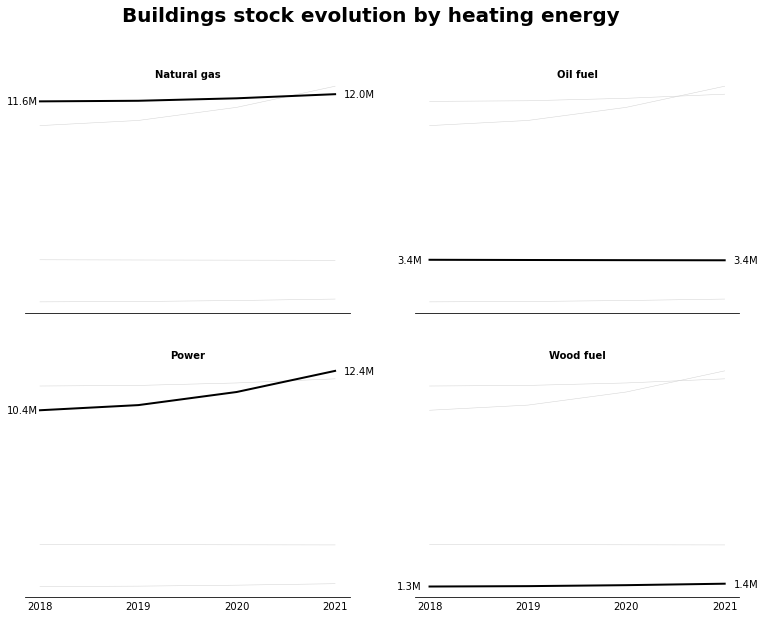

In [26]:
df_ep = df.groupby(['Heating energy']).sum()
economic_subplots(df_ep, 'Buildings stock evolution by heating energy',
                  format_axtitle=lambda x: x, format_val=lambda x: '{:.1f}M'.format(x / 1000000), n_columns=2)


### Renovation done

In [42]:
def transition_dict2dataframe(d):
    temp = {yr: df.unstack(df.index.names) for yr, df in d.items()}
    return pd.DataFrame(temp)

In [44]:
flow_renovation = transition_dict2dataframe(var_dict['flow_renovation_label_energy_dict'])

In [ ]:
t = var_dict['capex_total_dict'].copy()

In [55]:
subsidies = transition_dict2dataframe(var_dict['subsidies_total_dict'][('Energy performance', )].copy())

In [59]:
from utils import reindex_mi
s = reindex_mi(subsidies, flow_renovation.index, subsidies.index.names)

In [63]:
(s * flow_renovation).sum()

2019    1.649880e+07
2020    1.812089e+07
2021    2.044672e+07
dtype: float64

In [65]:
flow_renovation.sum()

2019     82567.100952
2020     91701.703330
2021    104688.912244
dtype: float64

In [64]:
s.sum()

2019    7.701931e+07
2020    7.553914e+07
2021    7.378558e+07
dtype: float64

In [28]:
var_dict['flow_renovation_label_energy_dict']

{2019: Heating energy final                                                                               Natural gas  \
 Energy performance final                                                                                     A   
 Occupancy status Housing type  Energy performance Heating energy Income class Income class owner                 
 Homeowners       Multi-family  A                  Natural gas    D1           D1                           NaN   
                                                                  D10          D10                          NaN   
                                                                  D2           D2                           NaN   
                                                                  D3           D3                           NaN   
                                                                  D4           D4                           NaN   
 ...                                                                      

## Total costs

## Public policies